In [93]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime
import scipy.stats
from datetime import datetime
import mpl_toolkits.mplot3d.axes3d as p3
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import interpolate
from sklearn.preprocessing import StandardScaler

In [123]:
plt.style.use('dark_background')
plt.style.use('default')

In [131]:
def generate_dekads(start, end):
    '''
    Generates list of timestamps of dekads between two dates
    
    Parameters
    ----------
    start : pd.datetime object
        Start date of list
    end : pd.datetime object
        end date of list
    '''
    
    dtrange = pd.date_range(start, end)
    days = list(range(len(dtrange))) #length of dtrange
    daysDF = pd.DataFrame({'Days': days}, index=dtrange)
    d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
    dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
    dekads = daysDF.groupby(dekaddates).mean()
    dekads = dekads.index
    
    return dekads

In [132]:
start = pd.datetime(2002,7,1)
end = pd.datetime(2019,4,30)

dekads = generate_dekads(start, end)

In [6]:
observations_tables = '/home/rgreen/tana-crunch/rgreen/crunch/DroughtEDM/Data/observations_tables/'

In [7]:
ndvi_orig_table = pd.read_csv(observations_tables+'ndvi_table_origT.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
precip_orig_table = pd.read_csv(observations_tables+'precip_table_origT.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
temp_orig_table = pd.read_csv(observations_tables+'temp_table_origT.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [119]:
ndvi_anom_table = pd.read_csv(observations_tables+'ndvi_table_anomT.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
precip_anom_table = pd.read_csv(observations_tables+'precip_table_anomT.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
temp_anom_table = pd.read_csv(observations_tables+'temp_table_anomT.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [120]:
ndvi_anom2_table = pd.read_csv(observations_tables+'ndvi_table_anom2T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
precip_anom2_table = pd.read_csv(observations_tables+'precip_table_anom2T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
temp_anom2_table = pd.read_csv(observations_tables+'temp_table_anom2T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [9]:
ndvi_multi_anom = '/home/rgreen/DroughtEDM/Data/Africa_simplex/ndvi_multi_anom/'

In [10]:
ndvi_simplex_cr = rasterio.open(ndvi_multi_anom + 'ndvi_ea_simplex_multi_anom_cr_pi18_ed6.tif').read(1)

In [11]:
ndvi_simplex_cr_ls = ndvi_simplex_cr.ravel().tolist()

In [12]:
low_skill_pixels = [i for i,x in enumerate(ndvi_simplex_cr_ls) if x < 0.1]
high_skill_pixels = [i for i,x in enumerate(ndvi_simplex_cr_ls) if x > 0.9]

In [99]:
low_skill_pixels[0]

28965

In [89]:
low_high_ts_df = pd.DataFrame(list(zip((ndvi_orig_table.loc[low_skill_pixels[0]]-100)/100, precip_orig_table.loc[low_skill_pixels[0]], temp_orig_table.loc[low_skill_pixels[0]], (ndvi_orig_table.loc[high_skill_pixels[0]]-100)/100, precip_orig_table.loc[high_skill_pixels[0]], temp_orig_table.loc[high_skill_pixels[0]])),
                             columns = ['NDVI_low_skill', 'Precip_low_skill', 'Temp_low_skill', 'NDVI_high_skill', 'Precip_high_skill', 'Temp_high_skill'])


In [92]:
low_high_ts_df.to_csv('/home/rgreen/DroughtEDM/low_high_ts_df.csv')

In [94]:
low_high_ts_df

,NDVI_low_skill,Precip_low_skill,Temp_low_skill,NDVI_high_skill,Precip_high_skill,Temp_high_skill
0,0.144390,1.679160,36.404186,0.203744,30.802542,34.103382
1,0.141678,1.020980,39.724049,0.219773,46.089069,26.121531
2,0.139467,2.987234,36.146961,0.226540,85.599159,27.353331
3,0.139063,2.071011,34.410019,0.256216,48.210403,28.406944
4,0.139063,2.326951,34.410019,0.316440,88.186401,28.406944
...,...,...,...,...,...,...
601,0.187316,4.717981,29.213200,0.195668,4.376093,42.416801
602,0.174848,4.647750,28.694613,0.191352,5.176301,44.614567
603,0.172505,11.601034,34.694084,0.185417,5.701899,45.197529
604,0.175353,11.477886,33.639904,0.181697,6.247706,41.846832


In [98]:
StandardScaler.fit_transform(list(low_high_ts_df.NDVI_low_skill))

TypeError: fit_transform() missing 1 required positional argument: 'X'

In [77]:
(ndvi_orig_table.loc[low_skill_pixels[0]]-100)/100

0      0.144390
1      0.141678
2      0.139467
3      0.139063
4      0.139063
         ...   
601    0.187316
602    0.174848
603    0.172505
604    0.175353
605    0.185766
Name: 28965, Length: 606, dtype: float64

In [ ]:
lowess(ndvi_orig_table.loc[low_skill_pixels[0]], np.arange(len(ndvi_orig_table.loc[low_skill_pixels[0]])), frac=0.02)[:, 1]

In [34]:
len(lowess(ndvi_orig_table.loc[low_skill_pixels[0]], np.arange(len(ndvi_orig_table.loc[low_skill_pixels[0]])), frac=0.02)[:, 1])

606

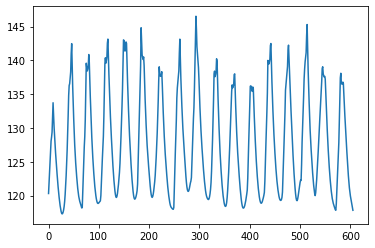

In [66]:
plt.plot((np.arange(len(ndvi_orig_table.loc[high_skill_pixels[0]]))), (lowess(ndvi_orig_table.loc[high_skill_pixels[0]], np.arange(len(ndvi_orig_table.loc[high_skill_pixels[0]])), frac=0.02)[:, 1]))
         

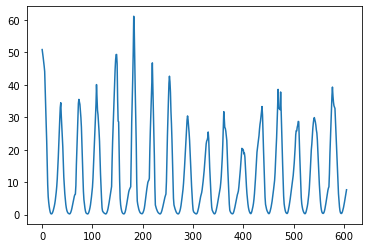

In [68]:
plt.plot((np.arange(len(precip_orig_table.loc[high_skill_pixels[0]]))), (lowess(precip_orig_table.loc[high_skill_pixels[0]], np.arange(len(precip_orig_table.loc[high_skill_pixels[0]])), frac=0.02)[:, 1]))
         

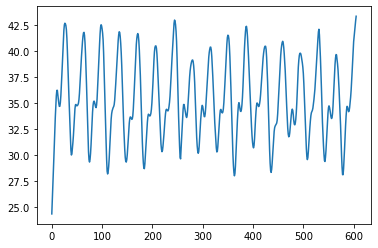

In [69]:
plt.plot((np.arange(len(temp_orig_table.loc[high_skill_pixels[0]]))), (lowess(temp_orig_table.loc[high_skill_pixels[0]], np.arange(len(temp_orig_table.loc[high_skill_pixels[0]])), frac=0.02)[:, 1]))
         

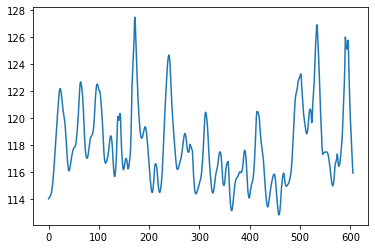

In [36]:
plt.plot((np.arange(len(ndvi_orig_table.loc[low_skill_pixels[0]]))), (lowess(ndvi_orig_table.loc[low_skill_pixels[0]], np.arange(len(ndvi_orig_table.loc[low_skill_pixels[0]])), frac=0.02)[:, 1]))
         

Text(0.5, 0, 'Land Surface Temperature')

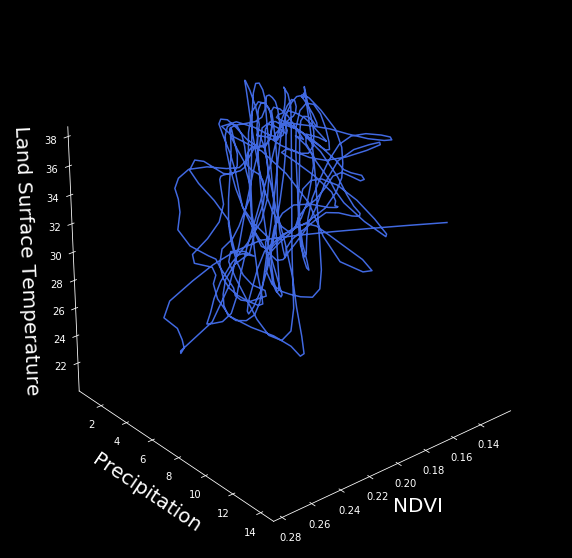

In [110]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = '3d')
ax.plot3D((lowess((ndvi_orig_table.loc[low_skill_pixels[0]]-100)/100, np.arange(len((ndvi_orig_table.loc[low_skill_pixels[0]]-100)/100)), frac=0.02)[:, 1]), (lowess(precip_orig_table.loc[low_skill_pixels[0]], np.arange(len(precip_orig_table.loc[low_skill_pixels[0]])), frac=0.02)[:, 1]), (lowess(temp_orig_table.loc[low_skill_pixels[0]], np.arange(len(temp_orig_table.loc[low_skill_pixels[0]])), frac=0.02)[:, 1]), c = 'royalblue')
ax.grid(False)
ax.view_init(30,50)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('NDVI', fontsize = 20, labelpad = 10)
ax.set_ylabel('Precipitation', fontsize = 20, labelpad = 10)
ax.set_zlabel('Land Surface Temperature', fontsize = 20, labelpad = 10)


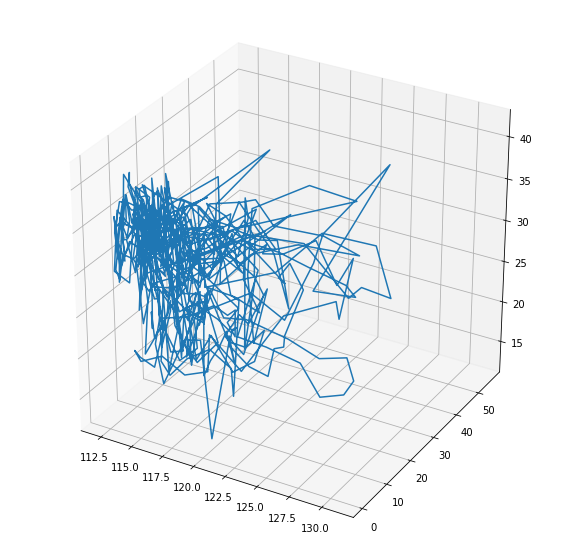

In [15]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = '3d')
ax.plot3D(ndvi_orig_table.loc[low_skill_pixels[0]], precip_orig_table.loc[low_skill_pixels[0]], temp_orig_table.loc[low_skill_pixels[0]])

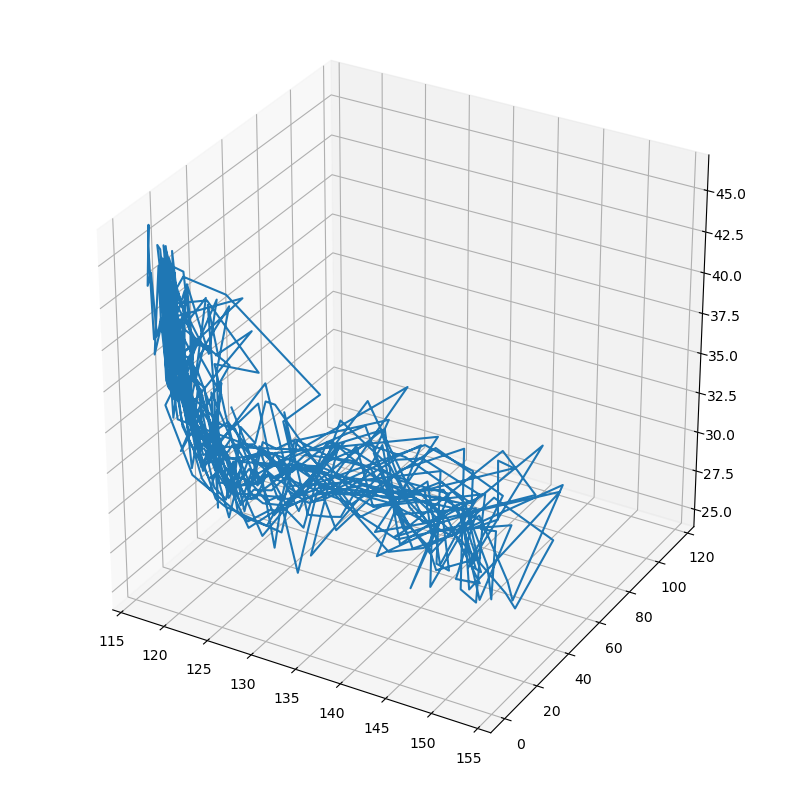

In [124]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = '3d')
ax.plot3D(ndvi_orig_table.loc[high_skill_pixels[0]], precip_orig_table.loc[high_skill_pixels[0]], temp_orig_table.loc[high_skill_pixels[0]])

Text(0.5, 0, 'Land Surface Temperature')

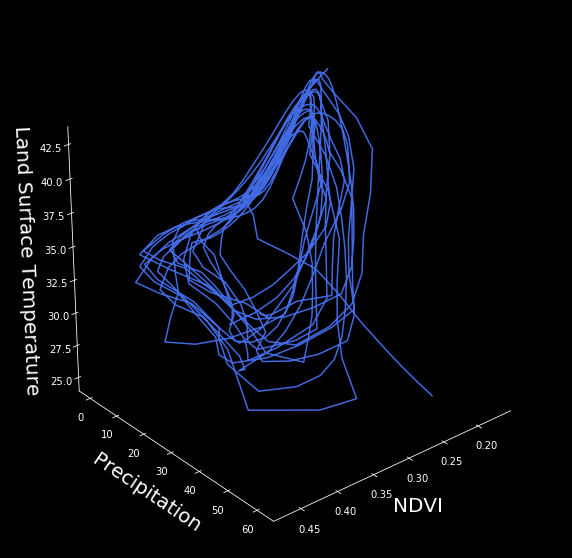

In [118]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = '3d')
ax.plot3D((lowess((ndvi_orig_table.loc[high_skill_pixels[0]]-100)/100, np.arange(len(ndvi_orig_table.loc[high_skill_pixels[0]])), frac=0.02)[:, 1]), (lowess(precip_orig_table.loc[high_skill_pixels[0]], np.arange(len(precip_orig_table.loc[high_skill_pixels[0]])), frac=0.02)[:, 1]), (lowess(temp_orig_table.loc[high_skill_pixels[0]], np.arange(len(temp_orig_table.loc[high_skill_pixels[0]])), frac=0.02)[:, 1]),c = 'royalblue')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(30,50)
ax.grid(False)
ax.set_xlabel('NDVI', fontsize = 20, labelpad = 10)
ax.set_ylabel('Precipitation', fontsize = 20, labelpad = 10)
ax.set_zlabel('Land Surface Temperature', fontsize = 20, labelpad = 10)


Text(0.5, 0, 'Land Surface Temperature')

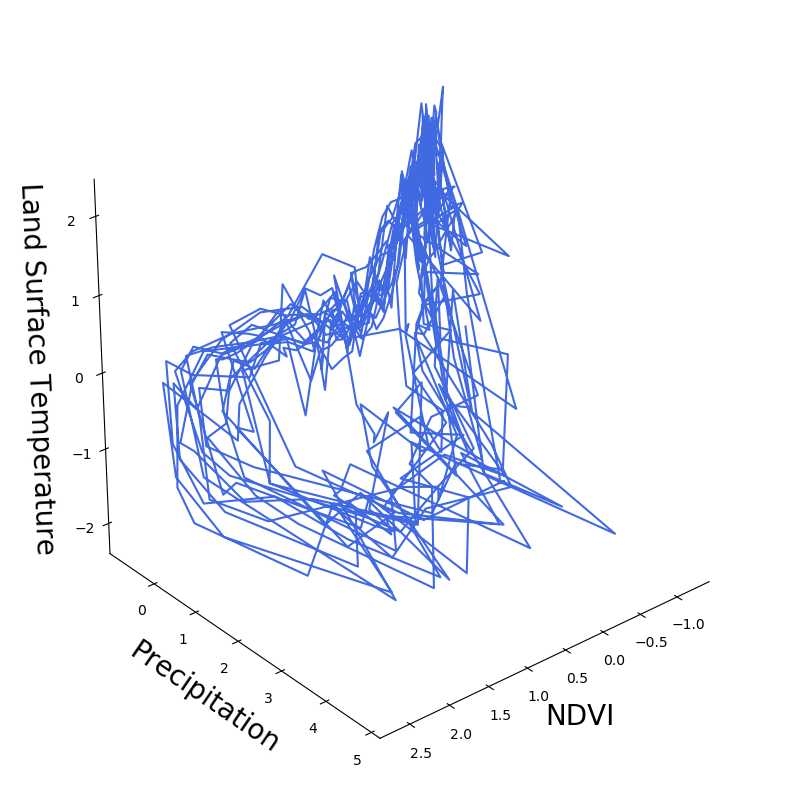

In [128]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = '3d')
ax.plot3D(ndvi_anom_table.loc[high_skill_pixels[0]], precip_anom_table.loc[high_skill_pixels[0]], temp_anom_table.loc[high_skill_pixels[0]], c = 'royalblue')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(False)
ax.view_init(30,50)
ax.set_xlabel('NDVI', fontsize = 20, labelpad = 10)
ax.set_ylabel('Precipitation', fontsize = 20, labelpad = 10)
ax.set_zlabel('Land Surface Temperature', fontsize = 20, labelpad = 10)

Text(0.5, 0, 'Land Surface Temperature')

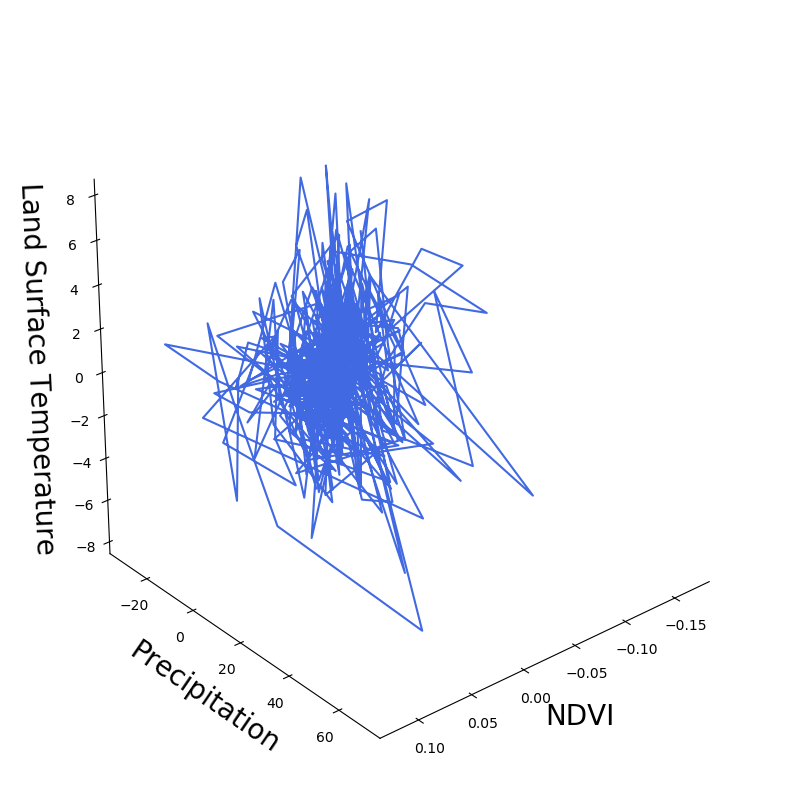

In [141]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = '3d')
ax.plot3D(ndvi_anom2_table.loc[high_skill_pixels[0]], precip_anom2_table.loc[high_skill_pixels[0]], temp_anom2_table.loc[high_skill_pixels[0]], c = 'royalblue')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(False)
ax.view_init(30,50)
ax.set_xlabel('NDVI', fontsize = 20, labelpad = 10)
ax.set_ylabel('Precipitation', fontsize = 20, labelpad = 10)
ax.set_zlabel('Land Surface Temperature', fontsize = 20, labelpad = 10)

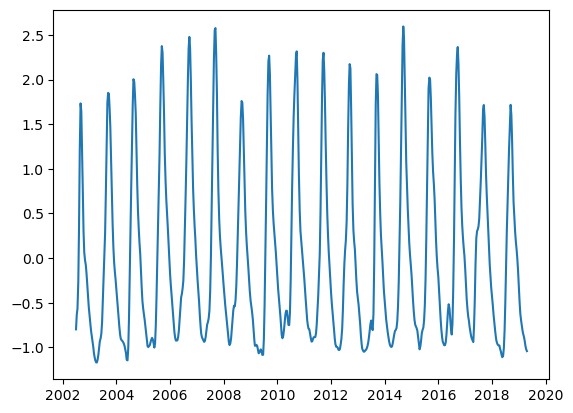

In [134]:
fig = plt.figure()
plt.plot(dekads, ndvi_anom_table.loc[high_skill_pixels[0]])

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


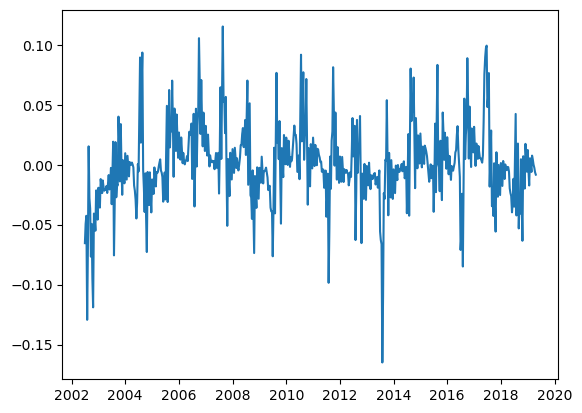

In [133]:
fig = plt.figure()
plt.plot(dekads, ndvi_anom2_table.loc[high_skill_pixels[0]])

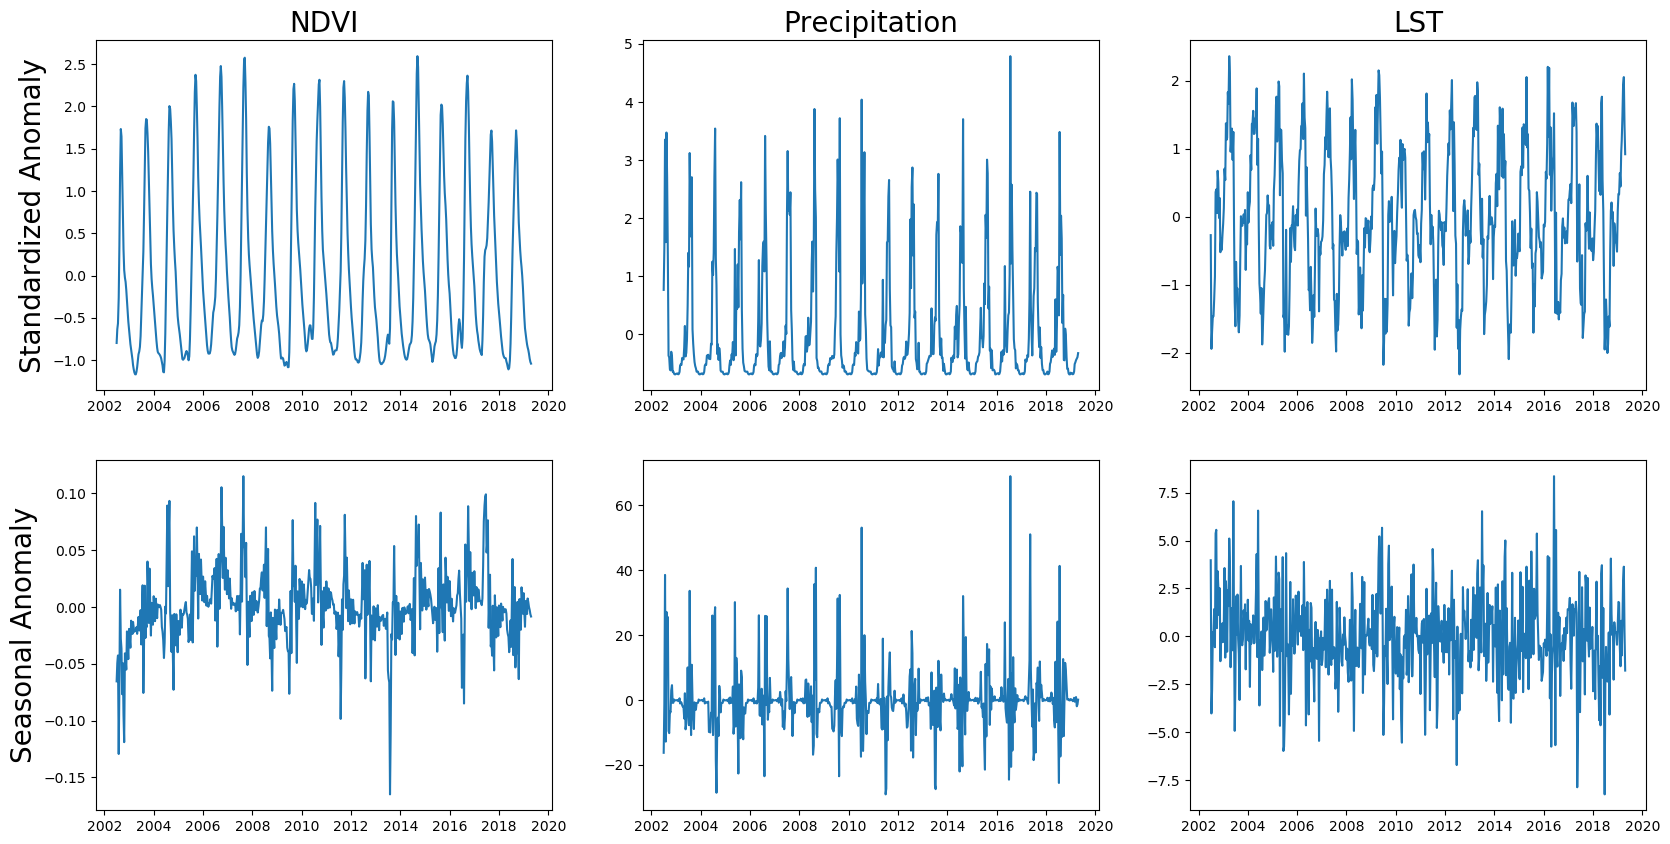

In [140]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20,10))

ax1.plot(dekads, ndvi_anom_table.loc[high_skill_pixels[0]])
ax1.set_ylabel('Standardized Anomaly', fontsize = 20)
ax1.set_title('NDVI', fontsize = 20)
ax2.plot(dekads, precip_anom_table.loc[high_skill_pixels[0]])
ax2.set_title('Precipitation', fontsize = 20)
ax3.plot(dekads, temp_anom_table.loc[high_skill_pixels[0]])
ax3.set_title('LST', fontsize = 20)
ax4.plot(dekads, ndvi_anom2_table.loc[high_skill_pixels[0]])
ax4.set_ylabel('Seasonal Anomaly', fontsize = 20)
ax5.plot(dekads, precip_anom2_table.loc[high_skill_pixels[0]])
ax6.plot(dekads, temp_anom2_table.loc[high_skill_pixels[0]])

In [142]:
pred_clim_anom = pd.read_csv('/home/rgreen/tana-crunch/rgreen/crunch/DroughtEDM/Data/predictions_tables/ndvi_ea_simplex_ed6_pi18_clim_anom.csv',
                             engine='c', low_memory=False, index_col=[0])

In [143]:
pred_anom = pd.read_csv('/home/rgreen/tana-crunch/rgreen/crunch/DroughtEDM/Data/predictions_tables/ndvi_ea_simplex_ed6_pi18_anom.csv',
                             engine='c', low_memory=False, index_col=[0])

In [144]:
dekads_pi18 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,10,21))

In [145]:
len(dekads_pi18)

619

In [ ]:
pred_clim_anom.insert(0, 'time',dekads_pi18)


In [151]:
pred_anom.insert(0, 'time', dekads_pi18)

In [197]:
pred_anom[:-18]

,time,0,1,2,3,4,5,6,7,8,...,392932,392933,392934,392935,392936,392937,392938,392939,392940,392941
0,2002-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,2019-03-11,0.297316,0.387243,0.187753,0.265649,0.189583,0.228610,-0.085738,-0.657869,-0.715028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,2019-03-21,-0.186302,0.222249,0.055391,0.168475,0.144399,-0.266088,-0.068325,-0.073643,-0.110008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,2019-04-01,-0.270910,0.115169,0.216524,0.452824,-0.093256,-0.129091,0.045692,0.122523,0.172842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599,2019-04-11,0.184094,0.394856,0.130561,0.436545,0.059215,0.080040,0.078396,-0.067804,0.393883,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
pred_anom[str(high_skill_pixels[0])][:-13]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
601   -0.917712
602   -0.665430
603   -0.713074
604   -0.550689
605   -0.650303
Name: 69701, Length: 606, dtype: float64

In [163]:
ndvi_anom_tableT = ndvi_anom_table.T

In [164]:
ndvi_anom_tableT.insert(0,'time', dekads)

In [167]:
ndvi_anom_tableT[high_skill_pixels[0]]

0     -0.798077
1     -0.634927
2     -0.566047
3     -0.263981
4      0.349009
         ...   
601   -0.880275
602   -0.924207
603   -0.984620
604   -1.022480
605   -1.042417
Name: 69701, Length: 606, dtype: float64

In [179]:
import seaborn as sns

In [182]:
len(ndvi_anom_tableT[high_skill_pixels[0]])

606

In [183]:
len(pred_anom[str(high_skill_pixels[0])][:-13])

606

In [186]:
from scipy import stats

In [193]:
ndvi_anom_tableT[5:]

,time,0,1,2,3,4,5,6,7,8,...,392932,392933,392934,392935,392936,392937,392938,392939,392940,392941
5,2002-08-21,1.218332,1.053565,0.704105,0.724557,1.298449,1.133370,1.374504,1.078897,1.071128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2002-09-01,1.314077,1.296879,0.925546,1.117066,1.357547,1.262671,1.325649,0.932892,0.999675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2002-09-11,0.860038,0.568543,0.078840,0.606488,0.583769,0.338127,0.287817,0.068272,0.386379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2002-09-21,0.436575,0.507100,0.082710,0.704352,0.628330,0.306155,0.081803,-0.029916,0.268390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2002-10-01,-0.923461,-0.746376,-0.938589,-0.368319,-0.148798,-0.576212,-1.020731,-0.890631,-0.660950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,2019-03-11,0.208073,0.026296,-0.284296,0.197938,-0.367827,-0.628079,-0.157488,-0.532811,-0.979176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,2019-03-21,0.522922,0.110877,-0.002413,0.636307,-0.054164,-0.157637,0.066254,-0.048598,-0.132028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,2019-04-01,0.331863,-0.081993,-0.378869,-0.353615,-0.445762,-0.467402,-0.187034,-0.058811,0.460797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
604,2019-04-11,0.306670,-0.136034,-0.296636,0.203851,-0.584455,-0.485288,-0.248363,-0.311625,-0.056771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
pred_anom[str(high_skill_pixels[0])]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
614    2.032499
615    2.086798
616    1.866095
617    1.479961
618    0.673998
Name: 69701, Length: 619, dtype: float64

In [198]:
nas1 = np.logical_or(np.isnan(ndvi_anom_tableT[high_skill_pixels[0]][5:].values), np.isnan(pred_anom[str(high_skill_pixels[0])][:-18].values))
r1,p1 = stats.pearsonr(list(ndvi_anom_tableT[high_skill_pixels[0]][5:][~nas1]), list(pred_anom[str(high_skill_pixels[0])][:-18][~nas1]))


In [199]:
r1

0.932815997758187

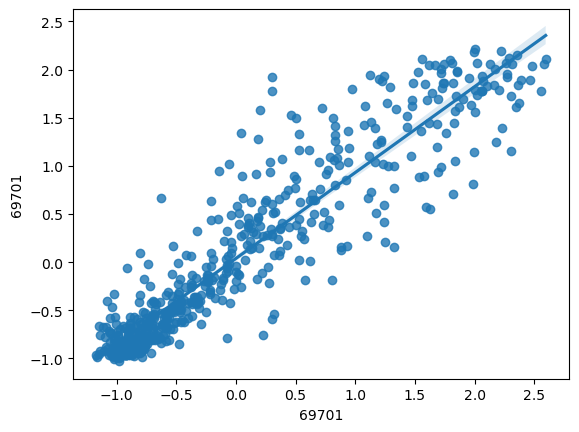

In [202]:
sns.regplot(ndvi_anom_tableT[high_skill_pixels[0]][5:], pred_anom[str(high_skill_pixels[0])][:-18])

In [206]:
ndvi_anom2_tableT = ndvi_anom2_table.T

In [208]:
ndvi_anom2_tableT

,0,1,2,3,4,5,6,7,8,9,...,392932,392933,392934,392935,392936,392937,392938,392939,392940,392941
0,0.002209,0.001815,0.000988,0.001304,0.002229,0.001881,0.001088,0.001160,0.000504,0.001880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001719,0.001302,0.000792,0.001375,0.002003,0.001648,0.000701,0.000570,0.000479,0.001813,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000250,-0.000455,-0.000879,-0.000435,0.001333,0.000391,0.000088,-0.000258,-0.000693,-0.000126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001174,0.000941,0.000558,0.001011,0.002314,0.001287,0.001190,0.000974,0.001113,0.002148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000898,0.000688,0.000128,0.000146,0.001956,0.001086,0.000955,0.000984,0.000679,0.000541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,-0.000050,-0.000579,-0.001353,-0.000171,-0.001592,-0.002035,-0.000382,-0.000951,-0.002374,-0.002149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,0.001230,-0.000329,-0.000497,0.001130,-0.000685,-0.000713,0.000190,0.000279,-0.000063,0.000395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,-0.000656,-0.001843,-0.002877,-0.002941,-0.003029,-0.002894,-0.001570,-0.001081,-0.000035,0.000216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
604,-0.000758,-0.002002,-0.002627,-0.001286,-0.003430,-0.002945,-0.001727,-0.001723,-0.001447,-0.000333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
pred_clim_anom[:-18]

,time,0,1,2,3,4,5,6,7,8,...,392932,392933,392934,392935,392936,392937,392938,392939,392940,392941
0,2002-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,2019-03-11,0.000549,0.000970,0.000298,0.000658,-0.000956,0.000059,-0.000167,0.000092,0.000411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,2019-03-21,0.000704,0.000938,0.000759,0.000434,-0.000036,0.000265,-0.000601,-0.000515,0.000490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,2019-04-01,0.000083,-0.000274,0.000638,0.001179,0.000113,-0.000006,0.000879,-0.000627,-0.000172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599,2019-04-11,0.001331,0.000094,-0.000514,-0.001408,-0.001289,-0.000868,-0.001412,-0.001077,-0.000779,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


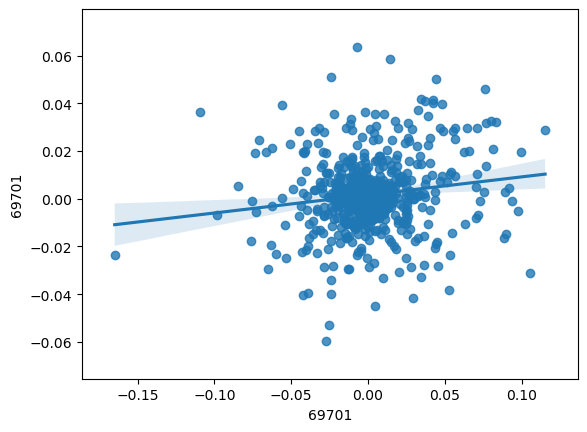

In [209]:
sns.regplot(ndvi_anom2_tableT[high_skill_pixels[0]][5:], pred_clim_anom[str(high_skill_pixels[0])][:-18])